In [13]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random
import torch.nn.functional as F

In [2]:
class DepthwiseConv(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1, groups=channels, bias=False)
        self.norm = nn.BatchNorm2d(channels)

    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        return x

In [3]:
class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.chanel_in = in_dim

        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1, bias=False)
        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1, bias=False)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1, bias=False)

        self.softmax = nn.Softmax(dim=-1)


    def forward(self, x):
        m_batchsize, C, width, height = x.size()

        # Compute query, key, value projections
        proj_query = self.query_conv(x).view(m_batchsize, -1, width * height).permute(0, 2, 1)  # B X (W*H) X C
        proj_key = self.key_conv(x).view(m_batchsize, -1, width * height)  # B X C X (W*H)
        proj_value = self.value_conv(x).view(m_batchsize, -1, width * height)  # B X C X (W*H)

        # Attention computation
        energy = torch.bmm(proj_query, proj_key)  # B X (W*H) X (W*H)
        attention = self.softmax(energy)  # B X (W*H) X (W*H)

        # Multiply value with attention
        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(m_batchsize, C, width, height)

        return out, attention.view(m_batchsize, width, height, width, height)

In [4]:
class PreNormComb(nn.Module):
    def __init__(self, in_dim):
        super(PreNormComb, self).__init__()
        self.conv = DepthwiseConv(in_dim)
        self.chanel_in = in_dim

        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1, bias=False)
        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1, bias=False)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1, bias=False)

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        batch_size, C, width, height = x.size()

        conv_out = self.conv(x)

        proj_query = self.query_conv(x).view(batch_size, -1, width * height).permute(0, 2, 1)  # B X (W*H) X C
        proj_key = self.key_conv(x).view(batch_size, -1, width * height)  # B X C X (W*H)
        proj_value = self.value_conv(x).view(batch_size, -1, width * height)  # B X C X (W*H)

        energy = torch.bmm(proj_query, proj_key)  # B X (W*H) X (W*H)

        conv_out_reshaped = conv_out.view(batch_size, C, width * height).permute(0, 2, 1)  # B X (W*H) X C

        combined = self.softmax(energy + torch.bmm(conv_out_reshaped, proj_key))

        out = torch.bmm(proj_value, combined)
        out = out.view(batch_size, C, width, height)

        return out, combined.view(batch_size, width, height, width, height)

In [5]:
class PostNormComb(nn.Module):
    def __init__(self, channels):
        super(PostNormComb, self).__init__()
        self.conv = DepthwiseConv(channels)
        self.attn = SelfAttention(channels)

    def forward(self, x):
        conv_out = self.conv(x)

        attn_out, map = self.attn(x)

        combined = attn_out + conv_out

        return combined,map


In [6]:
class ConvModAttn(nn.Module):
    def __init__(self, in_dim):
        super(ConvModAttn, self).__init__()
        self.conv = DepthwiseConv(in_dim)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1, bias=False)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        batch_size, C, width, height = x.size()

        conv_out = self.conv(x)

        attn_weights = self.softmax(conv_out.view(batch_size, C, -1))

        v = self.value_conv(x)

        combined = attn_weights.view(batch_size, C, width, height) * v

        return combined,attn_weights.view(batch_size, C, width, height)

In [7]:
class AttnModConv(nn.Module):
    def __init__(self, in_dim):
        super(AttnModConv, self).__init__()
        self.in_dim = in_dim

        self.conv = DepthwiseConv(in_dim)

        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1, bias=False)
        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1, bias=False)

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        batch_size, C, width, height = x.size()

        conv_out = self.conv(x)

        query = self.query_conv(x).view(batch_size, C, -1)  # B x C x (W*H)
        key = self.key_conv(x).view(batch_size, C, -1)  # B x C x (W*H)

        attention_scores = torch.bmm(query.permute(0, 2, 1), key)  # B x (W*H) x (W*H)

        attention_weights = self.softmax(attention_scores)  # B x (W*H) x (W*H)

        conv_out_flat = conv_out.view(batch_size, C, -1)  # B x C x (W*H)

        modulated_out = torch.bmm(conv_out_flat, attention_weights)  # B x C x (W*H)

        modulated_out = modulated_out.view(batch_size, C, width, height)

        return modulated_out, attention_weights.view(batch_size, width, height, width, height)


100%|██████████| 170498071/170498071 [00:05<00:00, 33821299.75it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


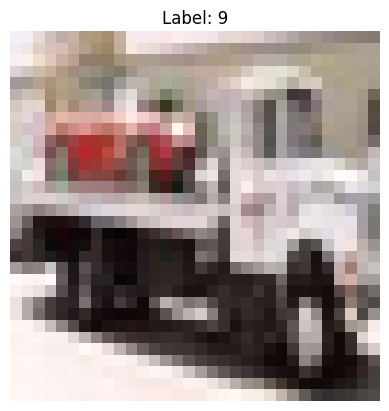

In [8]:
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)


# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Load the CIFAR-10 training set (for demonstration purposes)
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Fetch a random image from the dataset
def get_random_image(trainset):
    random_idx = random.randint(0, len(trainset) - 1)  # Generate a random index
    image, label = trainset[random_idx]  # Fetch the image and its label
    return image.unsqueeze(0), label  # Add batch dimension (1, C, H, W)

def denormalize_image(tensor):
    # The normalization we applied was (0.5, 0.5, 0.5) for mean and (0.5, 0.5, 0.5) for std.
    # Denormalizing by reversing the normalization
    tensor = tensor.squeeze(0)  # Remove batch dimension
    tensor = tensor * 0.5 + 0.5  # Reversing normalization to [0, 1] range
    return tensor

# Display the image using matplotlib
def show_image(tensor, label):
    # Denormalize image
    tensor = denormalize_image(tensor)

    # Convert tensor to numpy array and transpose (C, H, W) -> (H, W, C) for displaying
    np_image = tensor.permute(1, 2, 0).numpy()

    # Plot the image
    plt.imshow(np_image)
    plt.title(f"Label: {label}")
    plt.axis('off')  # Hide the axes
    plt.show()




image, label = get_random_image(trainset)
show_image(image, label)

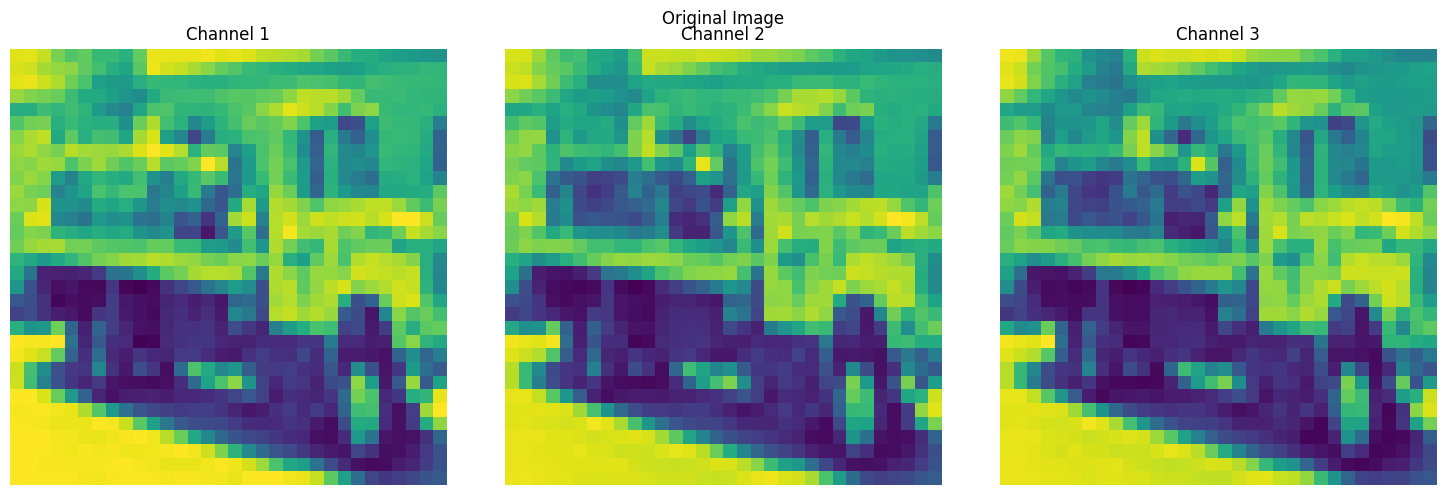

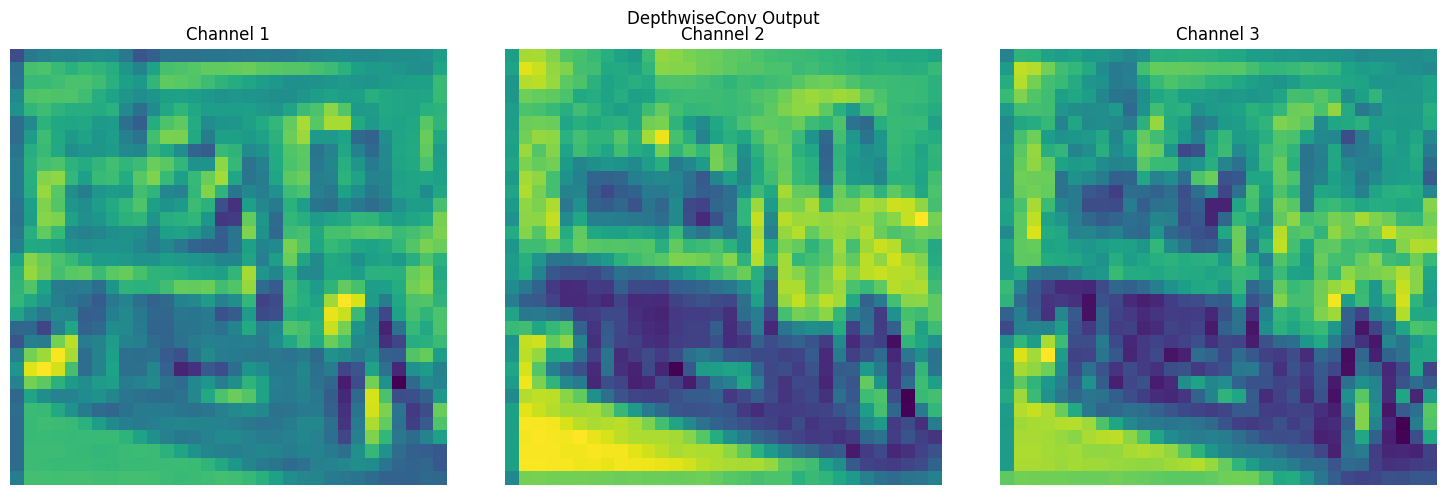

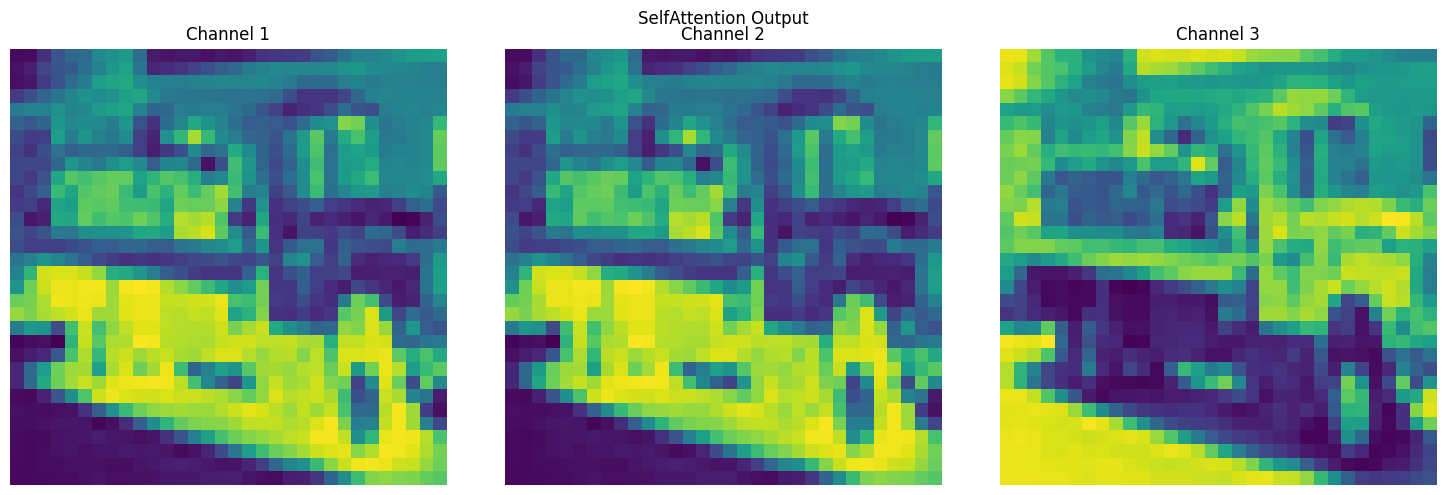

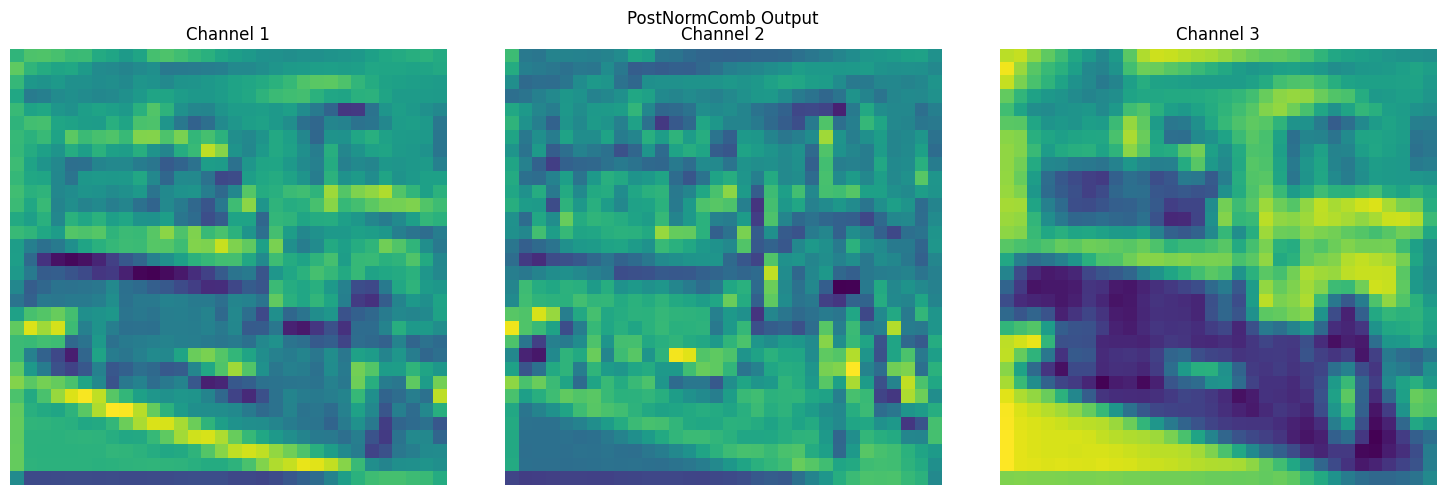

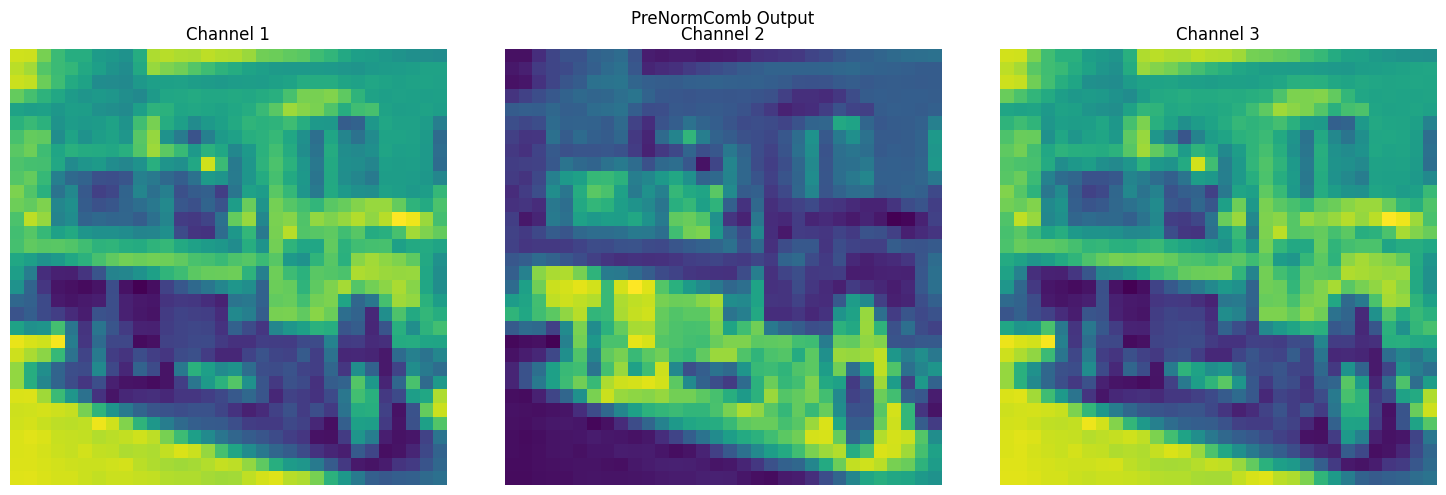

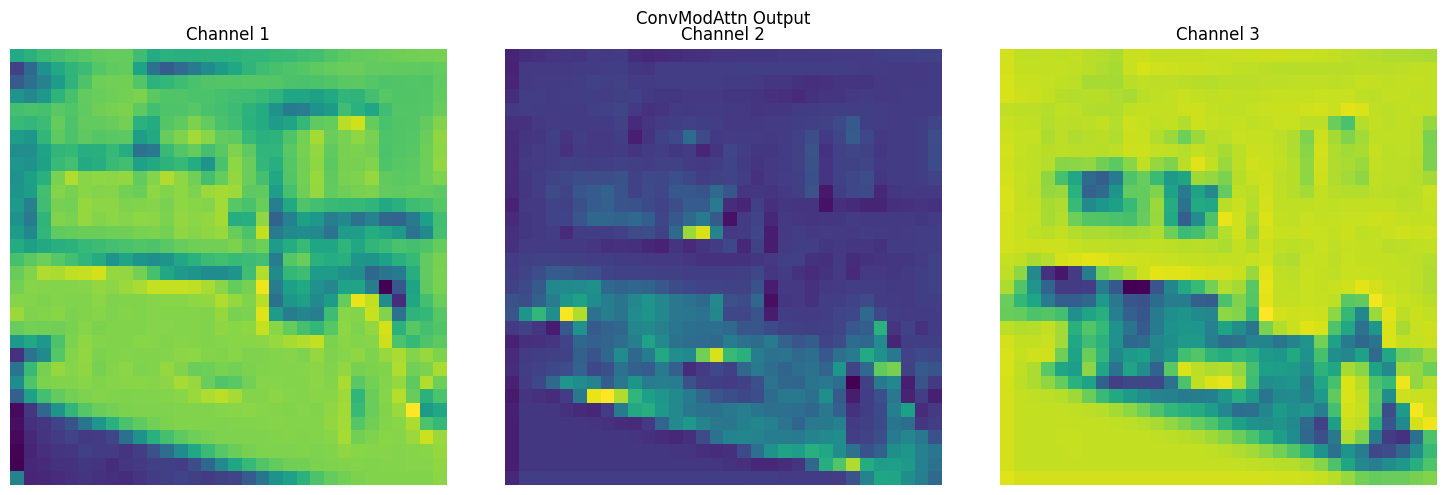

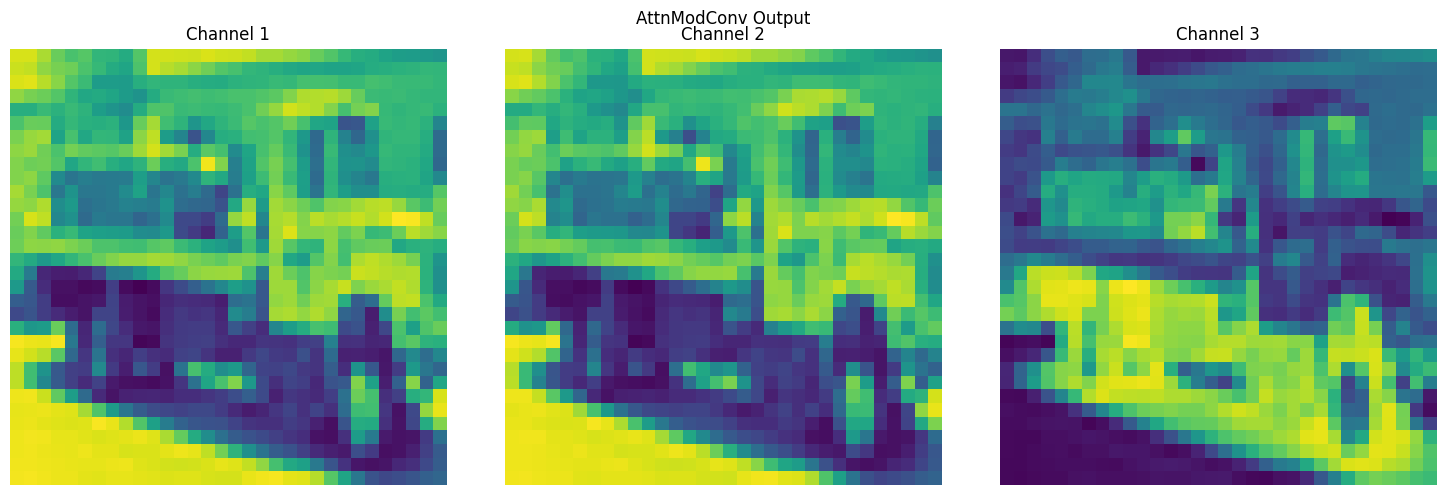

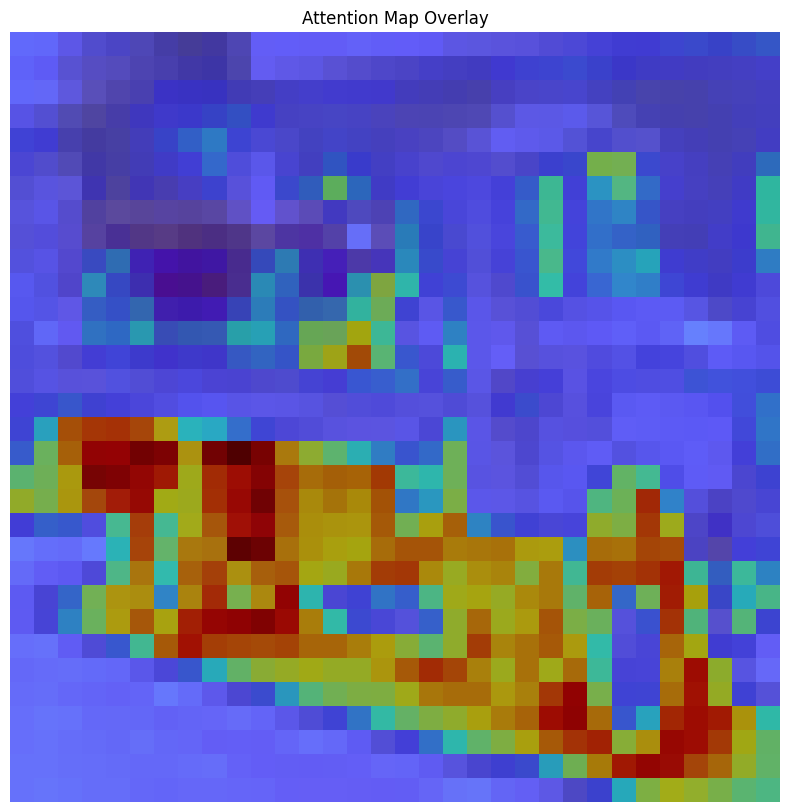

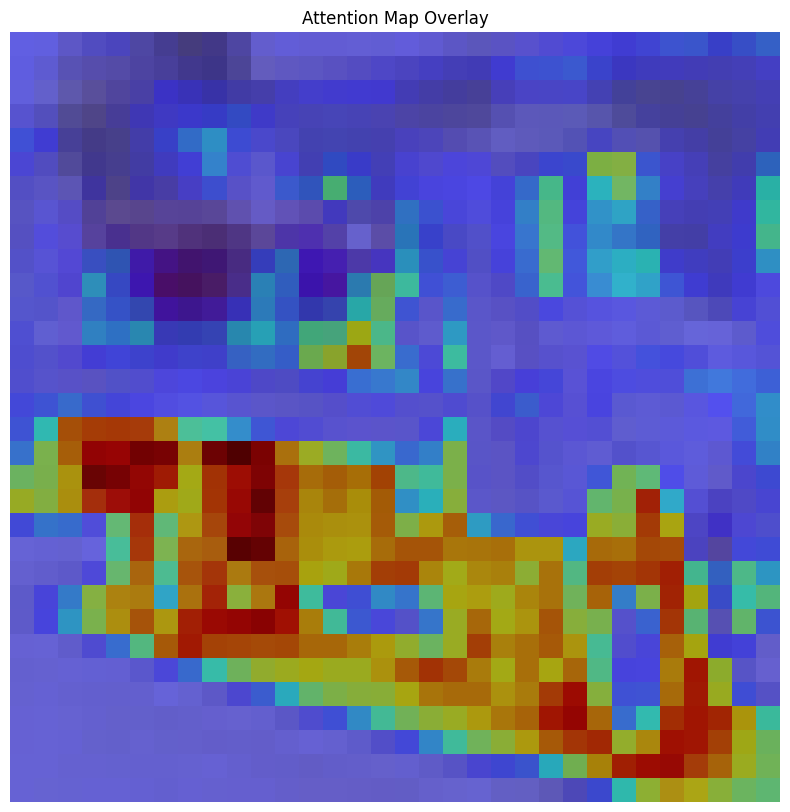

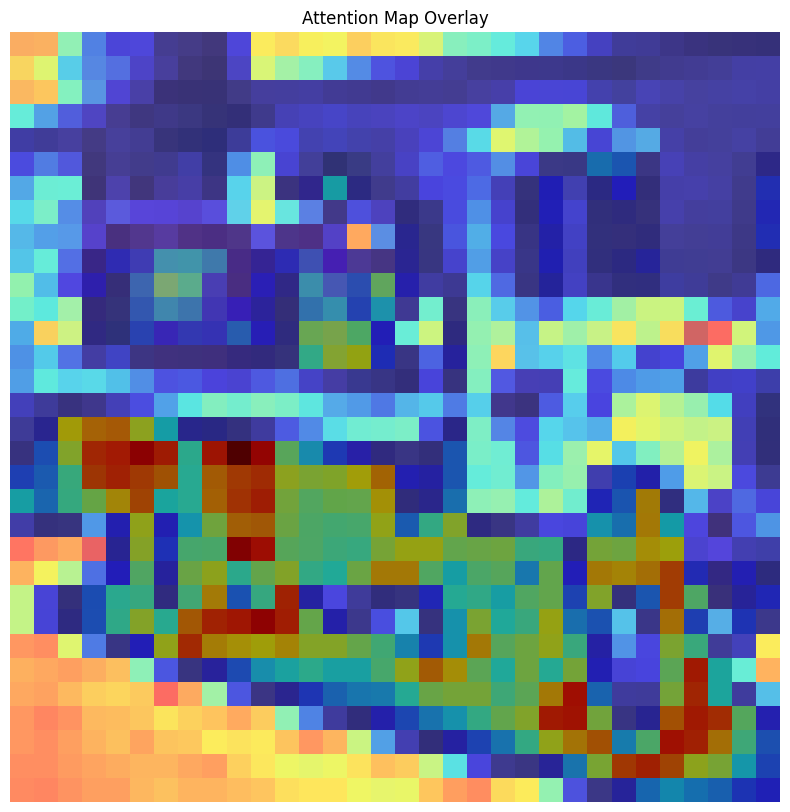

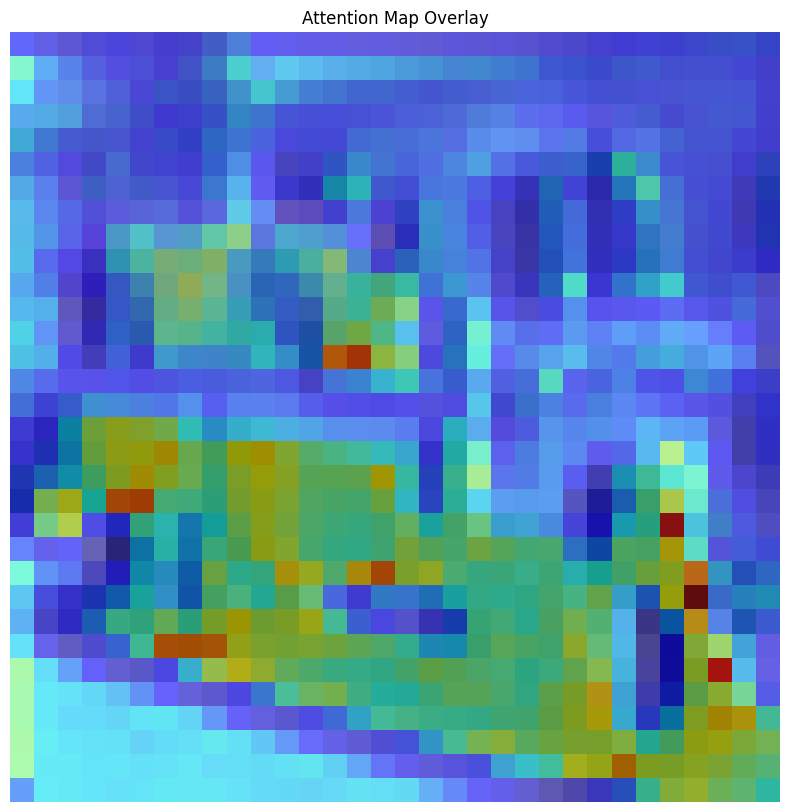

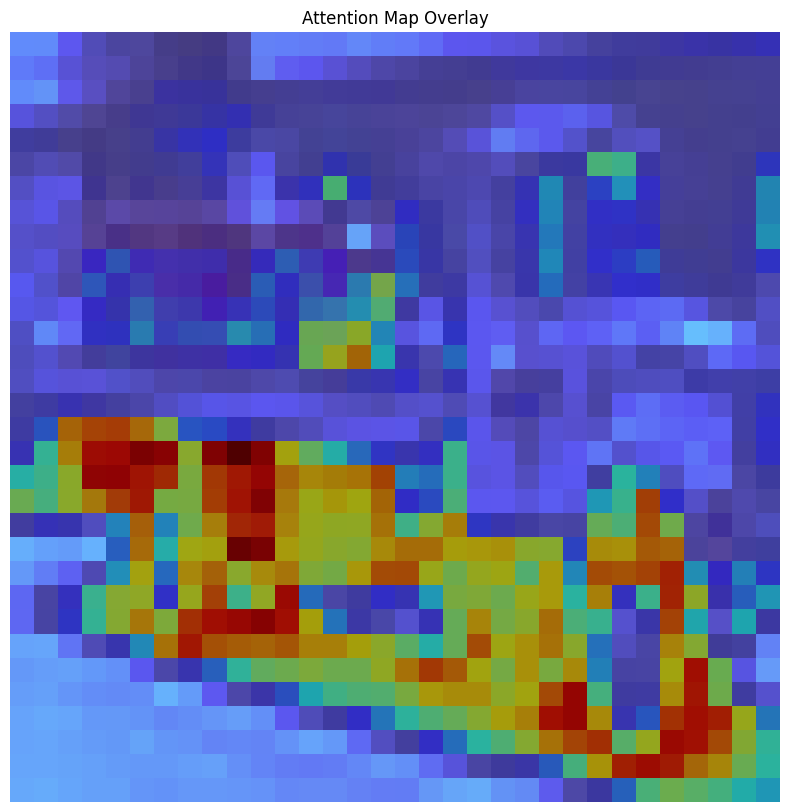

DepthwiseConv Statistics:
Min: -3.4869, 25%: -0.7745, Median: 0.1298, 75%: 0.7606, Max: 2.9475

SelfAttention Statistics:
Min: -0.1000, 25%: -0.0376, Median: -0.0268, 75%: 0.0340, Max: 0.0686

PostNormComb Statistics:
Min: -3.3478, 25%: -0.7121, Median: 0.0609, 75%: 0.7476, Max: 3.2810

PreNormComb Statistics:
Min: -0.6576, 25%: -0.0290, Median: 0.0737, 75%: 0.2221, Max: 0.7848

ConvModAttn Statistics:
Min: -0.0025, 25%: -0.0001, Median: -0.0000, 75%: 0.0000, Max: 0.0018

AttnModConv Statistics:
Min: -0.5438, 25%: -0.0926, Median: 0.0093, 75%: 0.1025, Max: 0.4437


In [15]:
# Initialize models
depthwise_conv = DepthwiseConv(3)
self_attention = SelfAttention(3)
post_norm_model = PostNormComb(3)
pre_norm_model = PreNormComb(3)
conv_mod_attn = ConvModAttn(3)
attn_mod_conv = AttnModConv(3)

# Function to visualize feature maps
def visualize_feature_map(feature_map, title):
    feature_map = feature_map.detach().cpu().numpy()[0]
    num_channels = feature_map.shape[0]

    fig, axs = plt.subplots(1, num_channels, figsize=(15, 5))
    fig.suptitle(title)

    for i in range(num_channels):
        axs[i].imshow(feature_map[i], cmap='viridis')
        axs[i].axis('off')
        axs[i].set_title(f'Channel {i+1}')

    plt.tight_layout()
    plt.show()

def visualize_attention_on_image(image, attention_map, alpha=0.6, cmap='jet'):
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())

    if attention_map.dim() == 5:  # (B, C, D, H, W)
        attention_map = attention_map.mean(dim=[0, 1, 2]).cpu().numpy()
    elif attention_map.dim() == 4:  # (C, D, H, W)
        attention_map = attention_map.mean(dim=[0, 1]).cpu().numpy()
    else:
        raise ValueError(f"Unexpected attention map shape: {attention_map.shape}")

    if attention_map.shape != image.shape[:2]:
        attention_map = torch.tensor(attention_map).unsqueeze(0).unsqueeze(0)
        attention_map = F.interpolate(attention_map,
                                      size=image.shape[:2],
                                      mode='bilinear',
                                      align_corners=False)
        attention_map = attention_map.squeeze().cpu().numpy()

    attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min())

    cmap = plt.get_cmap(cmap)
    attention_map_color = cmap(attention_map)

    composite = image * (1 - alpha) + attention_map_color[:, :, :3] * alpha

    plt.figure(figsize=(10, 10))
    plt.imshow(composite)
    plt.axis('off')
    plt.title("Attention Map Overlay")
    plt.show()

# Function to compute statistics
def compute_stats(tensor):
    np_array = tensor.detach().cpu().numpy().flatten()
    return np.percentile(np_array, [0, 25, 50, 75, 100])

# Function to print statistics
def print_stats(name, stats):
    print(f"{name} Statistics:")
    print(f"Min: {stats[0]:.4f}, 25%: {stats[1]:.4f}, Median: {stats[2]:.4f}, 75%: {stats[3]:.4f}, Max: {stats[4]:.4f}")

with torch.no_grad():
    depthwise_output = depthwise_conv(image)
    attention_output, attention_output_map = self_attention(image)
    post_norm_output, post_norm_output_map = post_norm_model(image)
    pre_norm_output, pre_norm_output_map = pre_norm_model(image)
    conv_mod_attn_output, conv_mod_attn_output_map = conv_mod_attn(image)
    attn_mod_conv_output, attn_mod_conv_output_map = attn_mod_conv(image)

visualize_feature_map(image, "Original Image")
visualize_feature_map(depthwise_output, "DepthwiseConv Output")
visualize_feature_map(attention_output, "SelfAttention Output")
visualize_feature_map(post_norm_output, "PostNormComb Output")
visualize_feature_map(pre_norm_output, "PreNormComb Output")
visualize_feature_map(conv_mod_attn_output, "ConvModAttn Output")
visualize_feature_map(attn_mod_conv_output, "AttnModConv Output")

visualize_attention_on_image(image[0], attention_output_map, alpha=0.6, cmap='jet')
visualize_attention_on_image(image[0], post_norm_output_map, alpha=0.6, cmap='jet')
visualize_attention_on_image(image[0], pre_norm_output_map, alpha=0.6, cmap='jet')
visualize_attention_on_image(image[0], conv_mod_attn_output_map, alpha=0.6, cmap='jet')
visualize_attention_on_image(image[0], attn_mod_conv_output_map, alpha=0.6, cmap='jet')

# Compute and print statistics
print_stats("DepthwiseConv", compute_stats(depthwise_output))
print_stats("\nSelfAttention", compute_stats(attention_output))
print_stats("\nPostNormComb", compute_stats(post_norm_output))
print_stats("\nPreNormComb", compute_stats(pre_norm_output))
print_stats("\nConvModAttn", compute_stats(conv_mod_attn_output))
print_stats("\nAttnModConv", compute_stats(attn_mod_conv_output))